# Using Python for neuroimaging data

The primary goal of this section is to become familiar with loading, modifying, saving, and visualizing neuroimages in Python. A secondary goal is to develop a conceptual understanding of the data structures involved, to facilitate diagnosing problems in data or analysis pipelines.

To these ends, we'll be exploring two libraries: [nibabel](http://nipy.org/nibabel/) and [nilearn](https://nilearn.github.io/). Each of these projects has excellent documentation. While this should get you started, it is well worth your time to look through these sites.

This notebook only covers nilearn, see the notebook [`nibabel.ipynb`](nibabel.ipynb) for more information about nibabel.

# Nilearn

[Nilearn](http://nilearn.github.io/index.html) labels itself as: *A Python module for fast and easy statistical learning on NeuroImaging data. It leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modelling, classification, decoding, or connectivity analysis.*

But it's much more than that. It is also an excellent library to **manipulate** (e.g. resample images, smooth images, ROI extraction, etc.) and **visulaize** your neuroimages.

So let's visit all three of those domains:

1. Image manipulation
2. Image visualization
3. Machine Learning

## Setup

In [1]:
# Image settings
import pylab as plt
%matplotlib inline

import numpy as np

Go to [Datalad](http://datasets.datalad.org/?dir=/openfmri) and download dataset 114 into the data folder.

Therefore [install datalad](https://www.datalad.org/get_datalad.html), and run the following command in your terminal.

`datalad install -s ///openfmri/ds000114`

Or use the [OpenNeuro](https://openneuro.org/datasets/ds000114/versions/1.0.1/download) page for the download.

## 1. Image manipulation with `nilearn`

### Let's create a mean image

If you use nibabel to compute the mean image, you first need to load the img, get the data and then compute the mean thereof. With nilearn you can do all this in just one line with `mean image`.

In [15]:
from nilearn import image as nli
import pylab as plt
import numpy as np
import nibabel as nb
%matplotlib inline

Now be aware of your OS and the path and which slashes are used.

In [3]:
#img = nli.mean_img('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')
path= 'C:\\Users\\vogelbacher\\Documents\\#1-UNI\\GitHub\\brainhack-marburg.github.io\\brainhack_2019\\notebooks\\'
img = nli.mean_img(path+'data\\ds000114\\sub-01\\ses-test\\func\\sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

Perfect! What else can we do with the `image` module?  
Let's see...

### Resample image to a template
Using `resample_to_img`, we can resample one image to have the same dimensions as another one. For example, let's resample an anatomical T1 image to the computed mean image above.

In [4]:
mean = nli.mean_img(path+'data\\ds000114\\sub-01\\ses-test\\func\\sub-01_ses-test_task-fingerfootlips_bold.nii.gz')
t1 = nli.load_img(path+'data\\ds000114\\sub-01\\ses-test\\anat\\sub-01_ses-test_T1w.nii.gz')
print([mean.shape, t1.shape])

[(64, 64, 30), (256, 156, 256)]


Let's resample the t1 image to the mean image.

In [5]:
resampled_t1 = nli.resample_to_img(t1, mean)
resampled_t1.shape

(64, 64, 30)

The image size of the resampled t1 image seems to be right. But what does it look like?

In [6]:
from nilearn import plotting
plotting.plot_anat(t1, title='original t1', display_mode='z')
plotting.plot_anat(resampled_t1, title='resampled t1', display_mode='z')

### Smooth an image
Using `smooth_img`, we can very quickly smooth any kind of MRI image. Let's for example take the mean image from above and smooth it with different FWHM values.

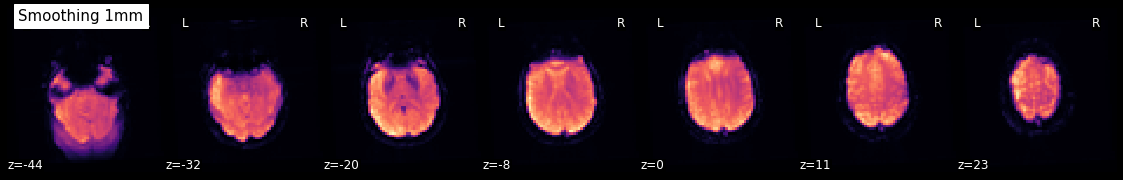

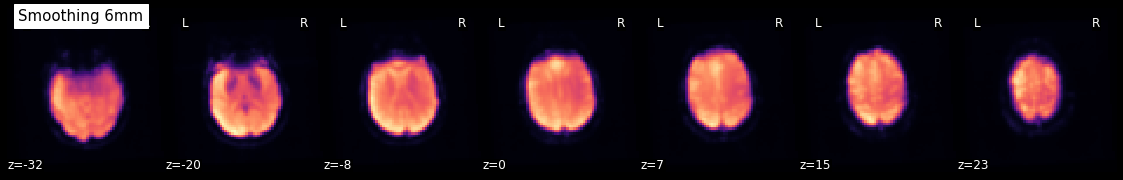

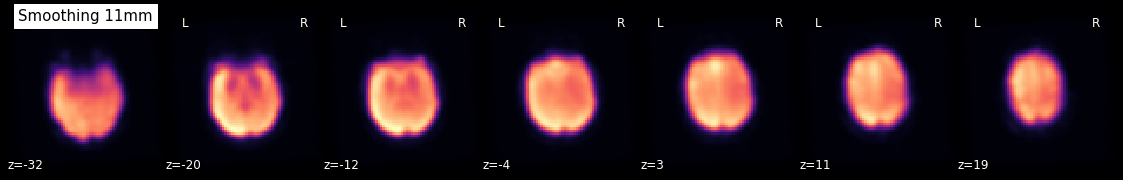

In [11]:
for fwhm in range(1, 12, 5):
    smoothed_img = nli.smooth_img(mean, fwhm)
    plotting.plot_epi(smoothed_img, title="Smoothing %imm" % fwhm,
                     display_mode='z', cmap=plt.cm.magma)

### Clean an image to improve SNR

Sometimes you also want to clean your functional images a bit to improve the SNR. For this, nilearn offers `clean_img`. You can improve the SNR of your fMRI signal by using one or more of the following options:

- detrend
- standardize
- remove confounds
- low- and high-pass filter

**Note:** Low-pass filtering improves specificity. High-pass filtering should be kept small, to keep some sensitivity.

First, let's load again a functional image

In [12]:
func = nli.load_img(path+'data\\ds000114\\sub-01\\ses-test\\func\\sub-01_ses-test_task-fingerfootlips_bold.nii.gz')
TR = func.header['pixdim'][4]

As a first step, let's just detrend the image.

In [13]:
func_d = nli.clean_img(func, detrend=True, standardize=False, t_r=TR)

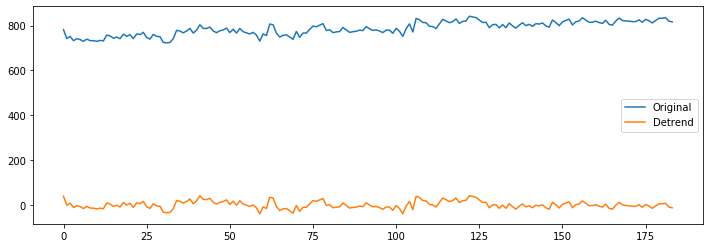

In [16]:
# Plot the original and detrended timecourse of a random voxel
x, y, z = [31, 14, 7]
plt.figure(figsize=(12, 4))
plt.plot(np.transpose(func.get_data()[x, y, z, :]))
plt.plot(np.transpose(func_d.get_data()[x, y, z, :]))
plt.legend(['Original', 'Detrend']);

Let's now see what `standardize` does:

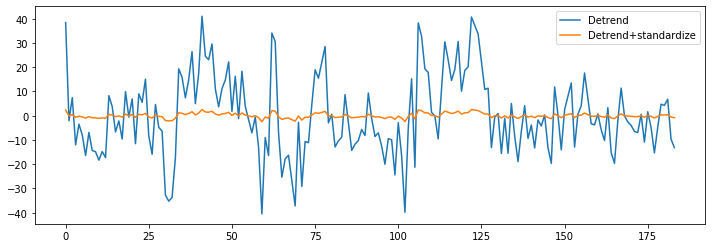

In [17]:
func_ds = nli.clean_img(func, detrend=True, standardize=True, t_r=TR)

plt.figure(figsize=(12, 4))
plt.plot(np.transpose(func_d.get_data()[x, y, z, :]))
plt.plot(np.transpose(func_ds.get_data()[x, y, z, :]))
plt.legend(['Detrend', 'Detrend+standardize']);

And as a final step, let's also remove the influence of the motion parameters from the signal.

In [20]:
func_ds_c = nli.clean_img(func, detrend=True, standardize=True, t_r=TR,
                          confounds=path+'data\\sub-01_ses-test_task-fingerfootlips_bold_mcf.par')

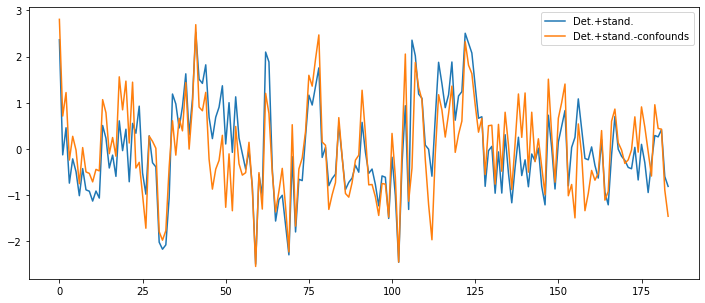

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(np.transpose(func_ds.get_data()[x, y, z, :]))
plt.plot(np.transpose(func_ds_c.get_data()[x, y, z, :]))
plt.legend(['Det.+stand.', 'Det.+stand.-confounds']);

### Mask an image and extract an average signal of a region

Thanks to nibabel and nilearn you can consider your images just a special kind of a numpy array. Which means that you have all the liberties that you are used to.

For example, let's take a functional image, (1) create the mean image thereof, than we (2) threshold it to only keep the voxels that have a value that is higher than 95% of all voxels. Of this thresholded image, we only (3) keep those regions that are bigger than 1000mm^3. And finally, we (4) binarize those regions to create a mask image.

So first, we load again a functional image and compute the mean thereof.

In [22]:
mean = nli.mean_img(path+'data\\ds000114\\sub-01\\ses-test\\func\\sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

Use `threshold_img` to only keep voxels that have a value that is higher than 95% of all voxels.

In [23]:
thr = nli.threshold_img(mean, threshold='99%')

Now, let's only keep those voxels that are in regions/clusters that are bigger than 1000mm^3.

In [24]:
voxel_size = np.prod(thr.header['pixdim'][1:4])  # Size of 1 voxel in mm^3
voxel_size

63.9996

Let's create the mask that only keeps those big clusters.

In [25]:
from nilearn.regions import connected_regions
cluster = connected_regions(thr, min_region_size=1000. / voxel_size, smoothing_fwhm=1)[0]

And finally, let's binarize this cluster file to create a mask.

In [26]:
mask = nli.math_img('np.mean(img,axis=3) > 0', img=cluster)

Now let us investigate this mask by visualizing it on the subject specific anatomy:

c:\program files\python36\lib\site-packages\nilearn\image\resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


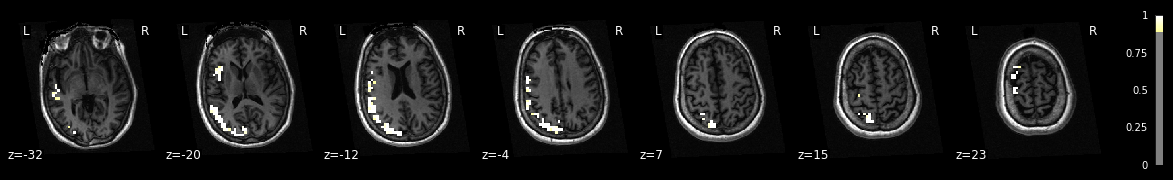

In [28]:
t1 = nli.load_img(path+'data\\ds000114\\sub-01\\ses-test\\anat\\sub-01_ses-test_T1w.nii.gz')
plotting.plot_stat_map(mask, bg_img=t1, display_mode='z', threshold=0.9, dim=-.5);

Next step is now to take this mask, apply it to the original functional image and extract the mean of the temporal signal.

In [29]:
# Apply mask to original functional image
from nilearn.masking import apply_mask

all_timecourses = apply_mask(func, mask)
all_timecourses.shape

(184, 825)

**Note:** You can bring the timecourses (or masked data) back into the original 3D/4D space with `unmask`:

In [30]:
from nilearn.masking import unmask
img_timecourse = unmask(all_timecourses, mask)

Compute mean trace of all extractet timecourses and plot the mean signal.

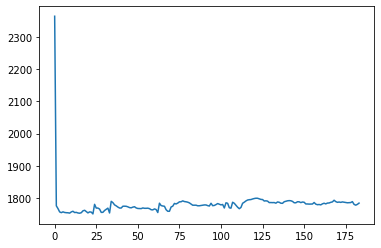

In [31]:
mean_timecourse = all_timecourses.mean(axis=1)
plt.plot(mean_timecourse)

### Independent Component Analysis

Nilearn gives you also the possibility to run an ICA on your data. This can either be on a single file or on multiple subjects.

In [32]:
# Import CanICA module
from nilearn.decomposition import CanICA

# Specify relevant parameters
n_components = 5
fwhm = 6.

In [33]:
# Specify CanICA object
canica = CanICA(n_components=n_components, smoothing_fwhm=fwhm,
                threshold=3., verbose=10, random_state=0, n_jobs=-1,
                standardize=True)

In [35]:
# Load input data
func = nli.load_img(path+'data\\ds000114\\sub-01\\ses-test\\func\\sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

In [36]:
# Run/fit CanICA on input data
canica.fit(func)

[MultiNiftiMasker.fit] Loading data from [Nifti1Image('C:\Users\vogelbacher\Documents\#1-UNI\GitHub\brainhack-marburg.github.io\brainhack_2019\notebooks\data\ds000114\sub-01\ses-test\func\sub-01_ses-test_task-fingerfootlips_bold.nii.gz')]
[MultiNiftiMasker.fit] Computing mask


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished


[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
       mask_args=None, mask_strategy='epi', memory=Memory(location=None),
       memory_level=0, n_components=5, n_init=10, n_jobs=-1, random_state=0,
       smoothing_fwhm=6.0, standardize=True, t_r=None, target_affine=None,
       target_shape=None, threshold=3.0, verbose=10)

In [37]:
# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)

Let's now visualize those components on the T1 image.

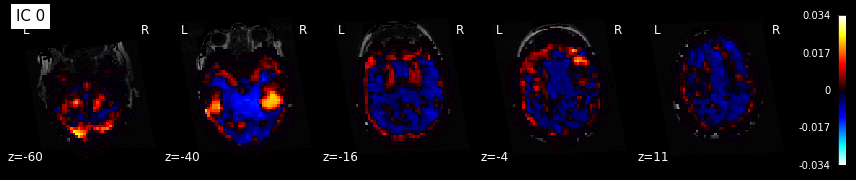

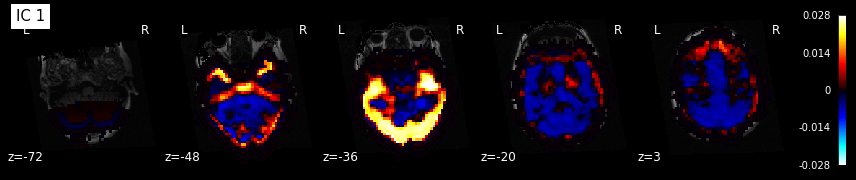

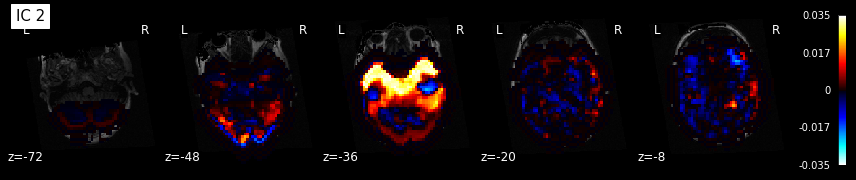

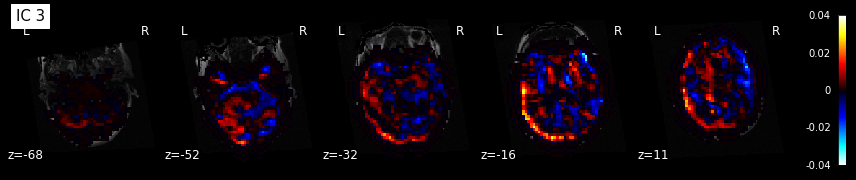

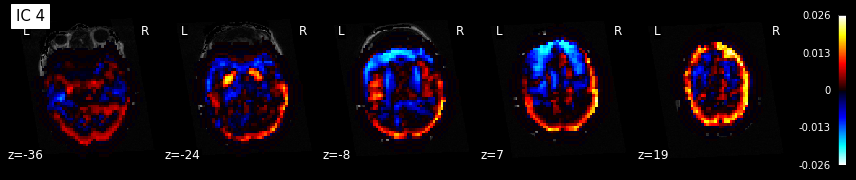

In [39]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map

anat = nli.load_img(path+'data\\ds000114\\sub-01\\ses-test\\anat\\sub-01_ses-test_T1w.nii.gz')

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=5, colorbar=True, bg_img=anat)

**Note:** The ICA components are not ordered, the visualization above and below therefore might look different from case to case. 

If you're now also curious about how those independent components, correlate with the functional image over time, you can use the following code to get some insights:

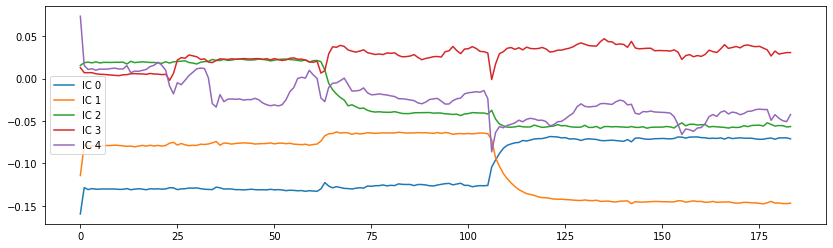

In [40]:
from scipy.stats.stats import pearsonr

# Get data of the functional image
orig_data = func.get_data()

# Compute the pearson correlation between the components and the signal
curves = np.array([[pearsonr(components_img.get_data()[..., j].ravel(),
      orig_data[..., i].ravel())[0] for i in range(orig_data.shape[-1])]
        for j in range(canica.n_components)])

# Plot the components
fig = plt.figure(figsize=(14, 4))
plt.plot(curves.T)
plt.legend(['IC %d' % i for i in range(canica.n_components)])

### Dictionary Learning

Recent work has shown that dictionary learning based techniques outperform ICA in term of stability and constitutes a better first step in a statistical analysis pipeline. Dictionary learning in neuro-imaging seeks to extract a few representative temporal elements along with their sparse spatial loadings, which constitute good extracted maps. Luckily, doing dictionary learning with `nilearn` is as easy as it can be.

DictLearning is a ready-to-use class with the same interface as CanICA. Sparsity of output map is controlled by a parameter alpha: using a larger alpha yields sparser maps.

In [41]:
# Import DictLearning module
from nilearn.decomposition import DictLearning

In [42]:
# Specify the dictionary learning object
dict_learning = DictLearning(n_components=n_components, n_epochs=1,
                             alpha=1., smoothing_fwhm=fwhm, standardize=True,
                             verbose=1, random_state=0, n_jobs=-1)

In [43]:
# As before, let's fit the model to the data
dict_learning.fit(func)

[MultiNiftiMasker.fit] Loading data from [Nifti1Image('C:\Users\vogelbacher\Documents\#1-UNI\GitHub\brainhack-marburg.github.io\brainhack_2019\notebooks\data\ds000114\sub-01\ses-test\func\sub-01_ses-test_task-fingerfootlips_bold.nii.gz')]
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
[DictLearning] Learning initial components


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[DictLearning] Computing initial loadings
[DictLearning] Learning dictionary


DictLearning(alpha=1.0, batch_size=20, detrend=True, dict_init=None,
             high_pass=None, low_pass=None, mask=None, mask_args=None,
             mask_strategy='epi', memory=Memory(location=None), memory_level=0,
             method='cd', n_components=5, n_epochs=1, n_jobs=-1, random_state=0,
             reduction_ratio='auto', smoothing_fwhm=6.0, standardize=True,
             t_r=None, target_affine=None, target_shape=None, verbose=1)

In [44]:
# Retrieve the independent components in brain space
components_img = dict_learning.masker_.inverse_transform(dict_learning.components_)

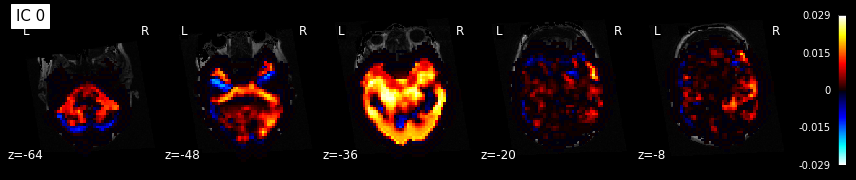

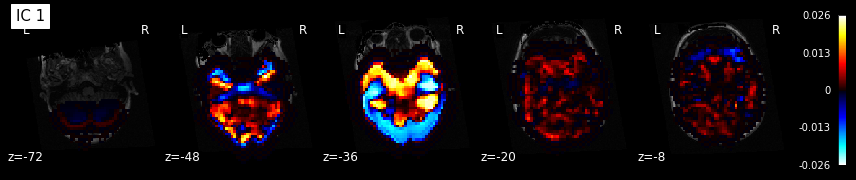

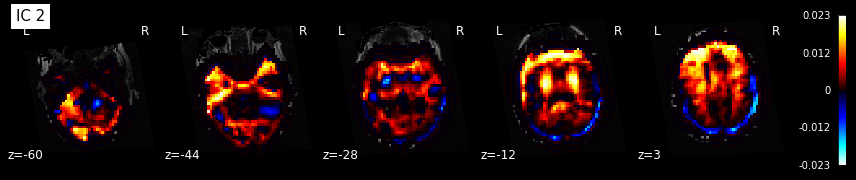

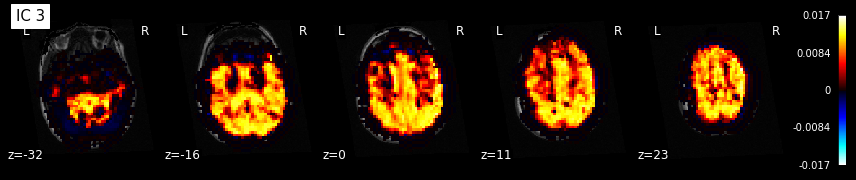

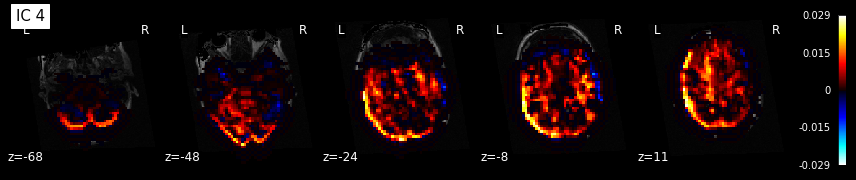

In [45]:
# Now let's plot the 5 components
for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=5, colorbar=True, bg_img=anat)

Maps obtained with dictionary leaning are often easier to exploit as they are less noisy than ICA maps, with blobs usually better defined. Typically, smoothing can be lower than when doing ICA. While dictionary learning computation time is comparable to CanICA, obtained atlases have been shown to outperform ICA in a variety of classification tasks.

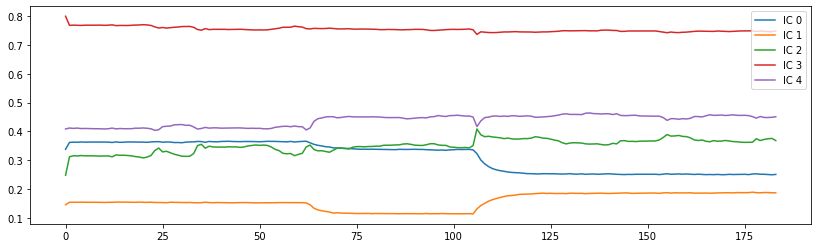

In [46]:
from scipy.stats.stats import pearsonr

# Get data of the functional image
orig_data = func.get_data()

# Compute the pearson correlation between the components and the signal
curves = np.array([[pearsonr(components_img.get_data()[..., j].ravel(),
      orig_data[..., i].ravel())[0] for i in range(orig_data.shape[-1])]
        for j in range(dict_learning.n_components)])

# Plot the components
fig = plt.figure(figsize=(14, 4))
plt.plot(curves.T)
plt.legend(['IC %d' % i for i in range(dict_learning.n_components)])

## 2. Image visualization with `nilearn`

Above, we've already seen some ways on how to visualize brain images with `nilearn`. And there are many more. To keep this notebook short, we will only take a look at some of them. For a complete list, see [nilearn's plotting section](http://nilearn.github.io/plotting/index.html).

**Note:** In most of the `nilearn`'s plotting functions, you can specify the value `output_file=example.png'`, to save the figure directly to a file.

In [47]:
%matplotlib inline

from nilearn import plotting

### Retrieve data from Internet

But before we can start, let's retrieve relevant datasets that we can use to plot. Luckily, nilearn comes with set of functions that download public data from Internet:

In [60]:
from nilearn import datasets

localizer_dataset = datasets.fetch_localizer_button_task()
#localizer_tmap = localizer_dataset.tmaps[0]
localizer_tmap = localizer_dataset.tmap

### Glass brain

A really cool way to visualize your brain images on the MNI brain is nilearn's `plot_glass_brain()` function. It gives you a good overview of all significant voxels in our image.

**Note**: It's important that your data is normalized to the MNI-template, as the overlay is otherwise not overlapping.

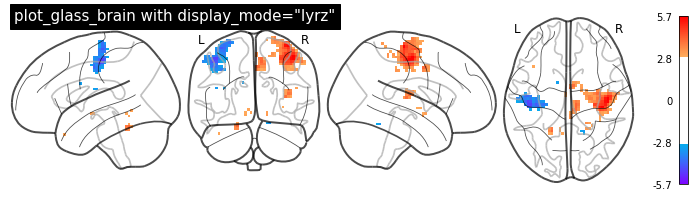

In [57]:
plotting.plot_glass_brain(localizer_tmap, threshold=3, colorbar=True,
                          title='plot_glass_brain with display_mode="lyrz"',
                          plot_abs=False, display_mode='lyrz', cmap=plt.cm.rainbow)

### Overlay functional image onto anatomical image

In this type of visualization, you can specify the axis through which you want to cut and the cut coordinates. `cut_coords` as integer 5 without a list implies that number of cuts in the slices should be maximum of 5.
The coordinates to cut the slices are selected automatically. But you could also specify the exact cuts with`cut_coords=[-10, 0, 10, 20]`.

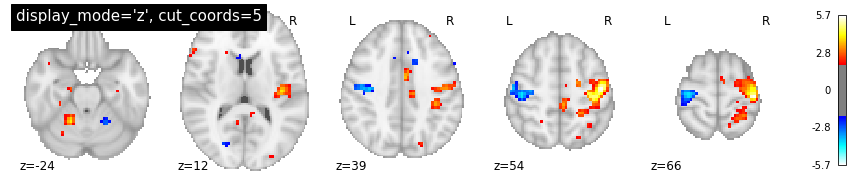

In [58]:
plotting.plot_stat_map(localizer_tmap, display_mode='z', cut_coords=5, threshold=2,
                       title="display_mode='z', cut_coords=5")

**Note**: `plot_stat_map()` can also be used to create figures with cuts in all directions, i.e. orthogonal cuts. For this, set `display_mode=ortho`:

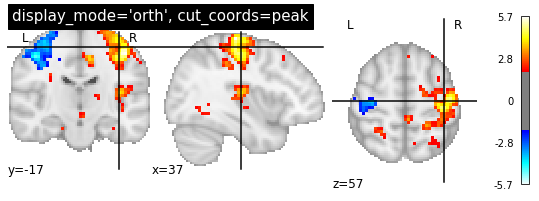

In [59]:
plotting.plot_stat_map(localizer_tmap, display_mode='ortho', threshold=2,
                       title="display_mode='orth', cut_coords=peak")

### Overlay two images ontop of each other

First freesurfer and frmiprep have to be run first. 

We can also create a plot that overlays different anatomical images. Let's show the FreeSurfer `aseg` segmentation over the T1 image:

In [63]:
plotting.plot_roi('/data/ds000114/derivatives/freesurfer/sub-01/mri/aseg.mgz',
                  '/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz',
                  dim=-1, cut_coords=(0, 0, 0))

ValueError: File not found: '/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz'

Notice that nilearn will accept an image or a filename equally. Also recall that `t1` was a NIfTI-1 image, while `aseg` is in a FreeSurfer `.mgz` file. Nilearn takes advantage of the common interface (data-affine-header) that nibabel provides for these different formats, and makes correctly aligned overlays.

### Use `add_edges` to see the overlay between two images

Let's assume we want to see how well our anatomical image overlays with the mean functional image. Let's first load those two files:

In [62]:
import nilearn.image as nli
t1 = nli.load_img('/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
mean = nli.mean_img('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

ValueError: File not found: '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'

Now, we can use the `plot_anat` plotting function to plot the background image, in this case the mean fMRI image. Followed by the `add_edges` function to overlay the edges of the anatomical image onto the mean image:

In [ ]:
display = plotting.plot_anat(mean, dim=-0.5)
display.add_edges(t1, color='r')

### Exercise 1:

Using the function `plot_epi()`, draw the image `mean` as a set of 5 slices spanning front to back. Suppress the background using the `vmin` option.

In [ ]:
plotting.plot_epi(mean, display_mode='y', cut_coords=5, vmin=100)

In [ ]:
# Create solution here

### 3D Surface Plot

One of the newest feature in nilearn is the possibility to project a 3D statistical map onto a cortical mesh using `nilearn.surface.vol_to_surf`. And than to display a surface plot of the projected map using `nilearn.plotting.plot_surf_stat_map`.

**Note:** Both of those modules require that your `matplotlib` version is 1.3.1 or higher and that your `nilearn` version is 0.4 or higher.

In [ ]:
# First, let's make sure to download some example dataset to visualize
from nilearn import datasets

# Download an example statistical map
localizer_dataset = datasets.fetch_localizer_button_task()
localizer_tmap = localizer_dataset.tmaps[0]

# Download the an example of a cortical mesh
fsaverage = datasets.fetch_surf_fsaverage5()

Project the statistical map from the volume onto the surface.

In [ ]:
from nilearn import surface
texture = surface.vol_to_surf(localizer_tmap, fsaverage.pial_right)

Now we are ready to plot the statistical map on the surface:

In [ ]:
%matplotlib inline
from nilearn import plotting
plotting.plot_surf_stat_map(fsaverage.infl_right, texture,
                            hemi='right', title='Inflated surface - right hemisphere',
                            threshold=1., bg_map=fsaverage.sulc_right,
                            view='lateral', cmap='cold_hot')
plotting.show()

Or another example, using the pial surface:

In [ ]:
plotting.plot_surf_stat_map(fsaverage.pial_left, texture,
                            hemi='left',  title='Pial surface - left hemisphere',
                            threshold=1., bg_map=fsaverage.sulc_left,
                            view='medial', cmap='cold_hot')
plotting.show()

## 3. Machine learning with `nilearn`

Although nilearn's visualizations are quite nice, its primary purpose was to facilitate machine learning in neuroimaging. It's in some sense the bridge between [nibabel](http://nipy.org/nibabel/) and [scikit-learn](http://scikit-learn.org/stable/). On the one hand, it reformats images to be easily passed to scikit-learn, and on the other, it reformats the results to produce valid nibabel images.

So let's take a look at a short MVPA example.

**Note**: This section is heavily based on the [nilearn decoding tutorial](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html).

### Setup

In [ ]:
%matplotlib inline
from nilearn import datasets, plotting, input_data, image
import numpy as np

### Load example dataset

Before we can do anything, we first need to download the example dataset. The whole dataset is almost 300MB big, and therefore might take some time to download.

In [ ]:
haxby_dataset = datasets.fetch_haxby(data_dir='data')

bold = haxby_dataset.func[0]
mask = haxby_dataset.mask_vt[0]
anat = haxby_dataset.anat[0]
labels = haxby_dataset.session_target[0]

!nib-ls $bold

### Masking and Un-masking data

We need our functional data in a 2D, sample-by-voxel matrix. To get that, we'll select a set of voxels in VT cortex defined by `mask`.

In [ ]:
plotting.plot_roi(mask, anat, cmap='Paired', dim=-.5)

`NiftiMasker` is an object that applies a mask to a dataset and returns the masked voxels as a vector at each time point.
`standardize=True` z-scores each voxel.

In [ ]:
masker = input_data.NiftiMasker(mask_img=mask, standardize=True)
samples = masker.fit_transform(bold)
print(samples)

Its shape corresponds to the number of time-points times the number of voxels in the mask.

In [ ]:
print(samples.shape)

To recover the original data shape (giving us a masked and z-scored BOLD series), we simply use the masker's inverse transform:

In [ ]:
masked_epi = masker.inverse_transform(samples)

Let's now visualize the masked epi.

In [ ]:
max_zscores = image.math_img("np.abs(img).max(axis=3)", img=masked_epi)
plotting.plot_stat_map(max_zscores, bg_img=anat, dim=-.5)

### Simple MVPA Example

Multi-voxel pattern analysis (MVPA) is a general term for techniques that contrast conditions over multiple voxels. It's very common to use machine learning models to generate statistics of interest.

In this case, we'll use the response patterns of voxels in VT cortex to predict the identity of the stimulus this subject was presented with. We'll use a support vector classifier (SVC) and leave-one-run-out cross-validation.

**Note:** This section is not intended to teach machine learning, but to demonstrate a simple nilearn pipeline.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score

The labels file contains metadata for each volume, indicating the stimulus type and run number.

In [ ]:
!head -n 10 $labels

Using `np.recfromcsv()`, we can refer to each column of this file by its header.

In [ ]:
attrs = np.recfromcsv(labels, delimiter=" ")
attrs.shape

In [ ]:
stimuli, runs = attrs['labels'], attrs['chunks']
print(np.unique(stimuli))

In [ ]:
np.unique(runs)

For simplicity, let's consider a two-class problem. Select the BOLD samples associated with bottles and shoes. We'll also need to select the corresponding stimuli and run numbers.

In [ ]:
condition_mask = (stimuli == b'bottle') | (stimuli == b'shoe')

samples_2class = samples[condition_mask]
stimuli_2class = stimuli[condition_mask]
runs_2class = runs[condition_mask]

samples_2class.shape

Leave-one-run-out cross-validation trains on `(n - 1)` runs, and classifies the remaining run, for each run. Mean (across runs) cross-validation accuracy is a common statistic for classification-based MVPA.

In [ ]:
svc = SVC(kernel='linear')
cva = cross_val_score(estimator=svc,
                      X=samples_2class,
                      y=stimuli_2class,
                      groups=runs_2class,
                      cv=LeaveOneGroupOut(),
                      n_jobs=-1)
print(cva, cva.mean(), sep='\n')

Another approach is to train a classifier on all of the data. This isn't useful for predicting, but we can read out the weight assigned to each voxel, giving a measure of its correlation with the stimulus type.

In [ ]:
svc.fit(samples_2class, stimuli_2class)
svc.coef_.shape

Since we have a value for each voxel, we can simply map this back to the volume using our `masker`, and visualize the weights.

In [ ]:
coef_vol = masker.inverse_transform(svc.coef_)
plotting.plot_stat_map(coef_vol, bg_img=anat, dim=-.5)

### Review

In this section, we explored nilearn's tools for interfacing neuroimaging data and machine learning algorithms. Central to this is the concept of the masker, which moves data from 4-dimensional BOLD time series to a 2-dimensional series of feature vectors, and can map resulting statistics back into the original BOLD volume. We used leave-one-run-out cross-validation to explore 2-class support vector classification, and mapped feature weights back into the volume.

# Conclusions

In the two notebooks about `nibabel` and `nilearn`, we've explored loading, saving and visualizing neuroimages, as well as how both packages can make some more sophisticated manipulations easy. At this point, you should be able to inspect and plot most images you encounter, as well as make modifications while preserving the alignment.